In [1]:
import jax.numpy as jnp
from jax import random, grad, jit
from jax.scipy.linalg import inv, svd, eigh, det

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial


key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
num_steps = 1000 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples

def create_stable_matrix(n, key):
    # Generate a symmetric random matrix
    A = random.normal(key, (n, n))
    A = (A + A.T) / 2
    
    # Ensure the matrix has a spectral radius < 1 for stability
    eigenvalues, eigenvectors = eigh(A)
    scaled_eigenvalues = eigenvalues / (jnp.abs(eigenvalues).max() + 0.1)  # Scale eigenvalues to ensure stability
    A_stable = eigenvectors @ jnp.diag(scaled_eigenvalues) @ eigenvectors.T
    
    return A_stable

# Model parameters
m0 = jnp.zeros((n,))  # Initial state mean
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
Q = jnp.eye(n) * 5.0    # Process noise covariance matrix (Sigma in Julia code)
R = jnp.eye(n) * 1.0    # Observation noise covariance matrix (Gamma)
inv_R = inv(R)
M = create_stable_matrix(n,key)    # State transition matrix (A)
H = jnp.eye(n)          # Observation matrix
observation_interval = 1

# State initialization
vd0 = m0 + random.multivariate_normal(key, jnp.zeros(n), C0)
vd = jnp.zeros((num_steps, n))
vd = vd.at[1].set(vd0)

key, _ = random.split(key)


def state_transition_function(x):
    return jnp.dot(M, x)

A_step = Partial(state_transition_function)


In [2]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum
from jax_filters import apply_filtering_fixed_linear
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix



In [3]:
observations, true_states = generate_true_states(key, num_steps, n, vd0, H, Q, R, A_step, observation_interval)

In [4]:
from functools import partial


@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, M, H, Q, R, y, key, N, num_steps, J0):
    states, covariances = apply_filtering_fixed_linear(m0, C0, y, K, n, M, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(states, covariances, n, A_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, states, covariances), y, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost


Steady-state K:
[[ 8.4026688e-01 -5.5582565e-04  1.9227718e-03 ... -1.7381124e-03
   1.1166887e-04  8.7673572e-04]
 [-5.5582571e-04  8.3913338e-01  6.7222939e-04 ...  4.6714439e-04
   4.2134593e-04  1.2299323e-03]
 [ 1.9227718e-03  6.7223026e-04  8.3999830e-01 ... -1.1818201e-03
  -6.4044574e-04  2.0543558e-03]
 ...
 [-1.7381150e-03  4.6714541e-04 -1.1818216e-03 ...  8.3963603e-01
  -1.1942829e-03  1.8443811e-03]
 [ 1.1166891e-04  4.2134707e-04 -6.4044609e-04 ... -1.1942824e-03
   8.4157896e-01  6.4192811e-04]
 [ 8.7673630e-04  1.2299323e-03  2.0543553e-03 ...  1.8443797e-03
   6.4192805e-04  8.3896738e-01]]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:24<00:00,  1.44s/it]

Optimized K: [[ 8.2863069e-01  5.5619766e-04 -8.0516975e-04 ... -8.7522611e-04
   3.4129415e-03 -1.5910424e-03]
 [-1.8834410e-04  8.2656431e-01 -1.3926302e-03 ... -1.8854886e-03
  -4.8157857e-03 -1.3160545e-03]
 [ 2.2192802e-03 -5.3720041e-03  8.2993156e-01 ...  1.7111851e-03
   3.4766685e-04 -3.0411661e-04]
 ...
 [-2.7975050e-04  5.3559942e-04 -1.1257720e-03 ...  8.2322979e-01
   7.1097282e-04 -2.2154695e-03]
 [-4.2177201e-04  5.7844981e-04 -1.1573100e-03 ...  3.5819532e-03
   8.2607168e-01  3.4500466e-04]
 [ 9.6651283e-04 -3.2144834e-03 -2.3463145e-03 ... -3.9156140e-03
  -7.6172687e-04  8.2891345e-01]]
Error: 0.1269476


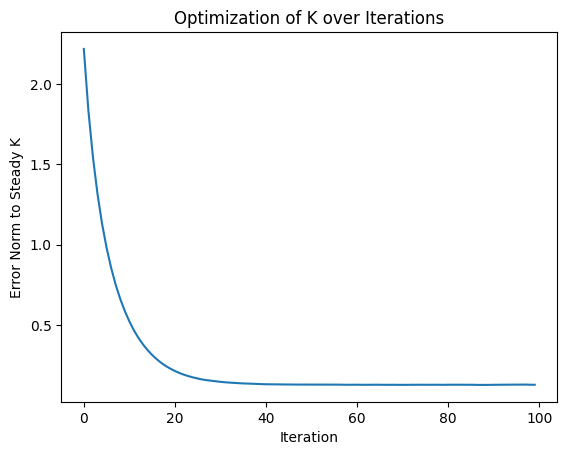

In [5]:

P = solve_discrete_are(M.T, H.T, Q, R)
# Compute steady-state Kalman gain K
K_steady = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
print("Steady-state K:")
print(K_steady)

# Define the gradient of the cost function
var_cost_grad = grad(var_cost, argnums=0)



# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.4
alpha = 1e-5
errs = []

for i in tqdm(range(100)):
    key, _ = random.split(key)
    # Update the gradient calculation to include all necessary parameters
    grad_K = var_cost_grad(K_opt, m0, C0, n, M, H, Q, R, observations, key, N, num_steps, J0)
    K_opt -= alpha * grad_K
    errs.append(jnp.linalg.norm(K_opt - K_steady))

# Results and visualization
print("Optimized K:", K_opt)
print("Error:", jnp.linalg.norm(K_opt - K_steady))
plt.plot(errs)
plt.xlabel('Iteration')
plt.ylabel('Error Norm to Steady K')
plt.title('Optimization of K over Iterations')
plt.show()




  0%|          | 0/100 [00:00<?, ?it/s]

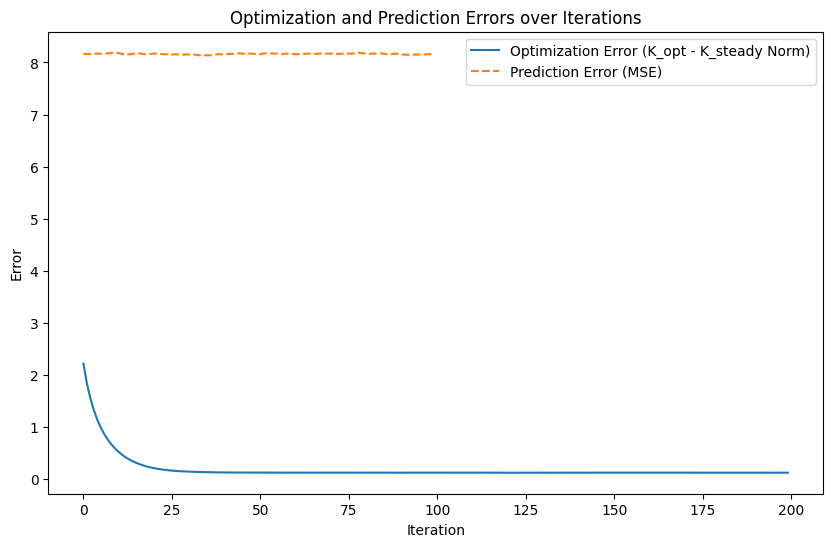

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy import linalg as jnpl
from tqdm.auto import tqdm



prediction_errors = [] 

for i in tqdm(range(100)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, M, H, Q, R, observations, key, N, num_steps, J0)
    K_opt -= alpha * grad_K
    
    # Apply filtering with the newly optimized K to generate state predictions
    predicted_states, _ = apply_filtering_fixed_linear(m0, C0, observations, K_opt, n, M, H, Q, R)
    
    prediction_error = jnpl.norm(predicted_states - true_states) ** 2 / len(true_states)
    prediction_errors.append(prediction_error)
    errs.append(jnpl.norm(K_opt - K_steady))

# Plotting both optimization error and prediction error
plt.figure(figsize=(10, 6))
plt.plot(errs, label='Optimization Error (K_opt - K_steady Norm)')
plt.plot(prediction_errors, label='Prediction Error (MSE)', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Optimization and Prediction Errors over Iterations')
plt.legend()
plt.show()


NameError: name 'fig' is not defined

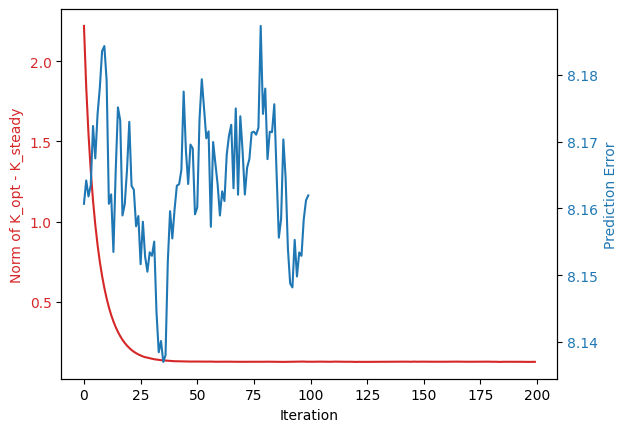

In [7]:
ig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Norm of K_opt - K_steady', color=color)
ax1.plot(errs, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Prediction Error', color=color)  # We already handled the x-label with ax1
ax2.plot(prediction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To make sure nothing is clipped
plt.title('Optimization and Prediction Errors over Iterations')
plt.show()